In [19]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Inference.VariationalGenerativeNetwork import VariationalGenerativeNetwork
import functools
from Tools.NNtools import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [435]:
@functools.lru_cache(maxsize=None)
def getsquareindex(s):
    a,b = np.triu_indices(s,1);
    return a,b

def qtoq2(q, N=100):
    x = q.sample(N)
    D = torch.nn.functional.pdist(x)
    i = D.argmin()
    a,b = np.triu_indices(len(x),1)
    return x[a[i],:]

In [3]:
# load data and make it in proper shape
data = torch.load('Data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [4]:
model = nn.Sequential( nn.Linear(1, 50),
                       nn.Tanh(), 
                       nn.Linear(50, 1),
                     ).to(device)

In [5]:
param_count = get_param(model).shape[0]

In [6]:
flip_parameters_to_tensors(model)

In [7]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [8]:
def logprior(x):
    return prior.log_prob(x)

In [9]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [10]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [11]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [659]:
class VariationalGenerativeNetwork(nn.Module):
    def __init__(self, nntransform, lat_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(VariationalGenerativeNetwork, self).__init__()
        self.device = device
        self.lat_dim = lat_dim
        
        self.mfvar = MeanFieldVariationalDistribution(lat_dim,mu,sigma)
        self.nntransform = nntransform
        
          
    def sample(self, n=1):
        return self.nntransform(self.mfvar.sample(n))

In [686]:
lat_dim = 5

In [697]:
nntransform = nn.Sequential( 
                       nn.Linear(lat_dim, 23),
                       nn.Tanh(), 
                       nn.Linear(23, param_count),
                     )

In [698]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        torch.nn.init.normal_(m.bias, mean=0.0, std=1.0)

In [699]:
nntransform.apply(init_weights)

Sequential(
  (0): Linear(in_features=5, out_features=23, bias=True)
  (1): Tanh()
  (2): Linear(in_features=23, out_features=151, bias=True)
)

In [700]:
q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device='cpu')

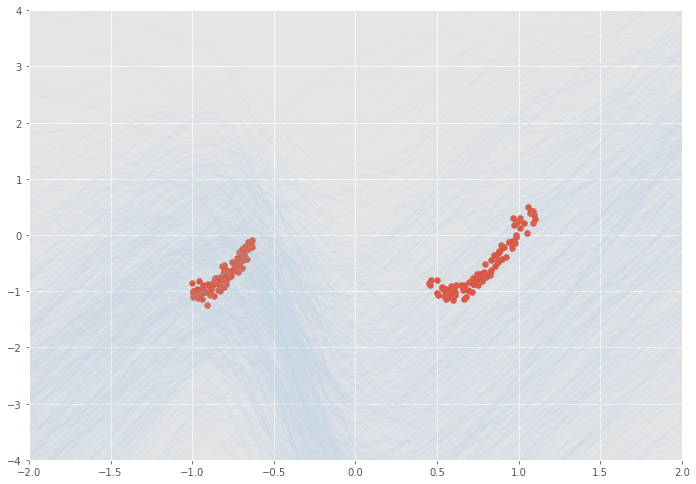

In [691]:
show_variational_posterior_predictive(q)

In [692]:
list(q.named_parameters())

[('mfvar.mu', Parameter containing:
  tensor([0., 0., 0., 0., 0.], requires_grad=True)),
 ('mfvar.rho', Parameter containing:
  tensor([0.5413, 0.5413, 0.5413, 0.5413, 0.5413], requires_grad=True)),
 ('nntransform.0.weight', Parameter containing:
  tensor([[-0.0758,  0.1620,  0.0035, -0.1969, -0.1560],
          [ 0.1470, -0.0335,  0.0011, -0.1887, -0.2857],
          [-0.4031, -0.1102, -0.1666, -0.2273,  0.1728],
          [ 0.2046,  0.2510,  0.0347, -0.1945, -0.0078],
          [ 0.3859,  0.1731,  0.0496, -0.2764, -0.1032],
          [-0.1461, -0.1616,  0.2626,  0.1831,  0.2147],
          [ 0.0834, -0.2592,  0.2882, -0.0549, -0.1494],
          [-0.0219,  0.3280,  0.0393,  0.1936, -0.0083],
          [ 0.1088, -0.0238, -0.2121,  0.1445, -0.2896],
          [-0.0049, -0.0436,  0.3124,  0.1970,  0.3381],
          [ 0.1311, -0.0039, -0.3125,  0.4958,  0.1337],
          [ 0.1641,  0.0463, -0.3088, -0.0315,  0.3669],
          [ 0.0518, -0.1148, -0.1737, -0.0642,  0.2359],
          [ 

# Variational Distribution #

In [701]:
n_samples_ELBO = 100

In [702]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.9)

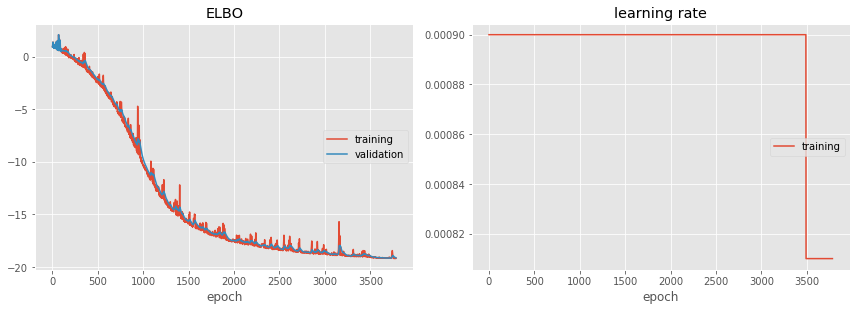

ELBO:
training   (min:  -19.207, max:    2.073, cur:  -19.167)
validation (min:  -19.161, max:    2.073, cur:  -19.129)

learning rate:
training   (min:    0.001, max:    0.001, cur:    0.001)


KeyboardInterrupt: 

In [707]:
%matplotlib inline
liveloss = PlotLosses()
mmELBO = 0.0
beta = 0.95
for t in range(100000):
    logs = {}
    optimizer.zero_grad()

    LL = []
    for j in range(n_samples_ELBO):
        z = q.sample(1)
        LP = loglikelihood(z, model, x_data, y_data, sigma_noise=0.1)
        LL.append(LP)
    eLL = torch.stack(LL).mean()
    
    #z = qtoq2(q,1000)
    #D2 = -logprior(z).squeeze(0)
    
    LQ = []
    for _ in range(n_samples_ELBO):
        z = qtoq2(q,100)
        LQ.append(-logprior(z))
    D2 = torch.logsumexp(torch.stack(LQ),dim=0).squeeze(0)
    
    L = -(eLL-D2)
    
    L.backward()
    optimizer.step()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    if t < 100:
        mmELBO = L.detach().clone().cpu().numpy()
    else:
        mmELBO = (beta)*mmELBO + (1-beta)*L.detach().clone().cpu().numpy()
    
    scheduler.step(mmELBO)
    
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['val_ELBO'] = np.array(mmELBO)
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
  
    if t % 20 == 0:
        liveloss.draw()

    if learning_rate < 0.00001:
        break

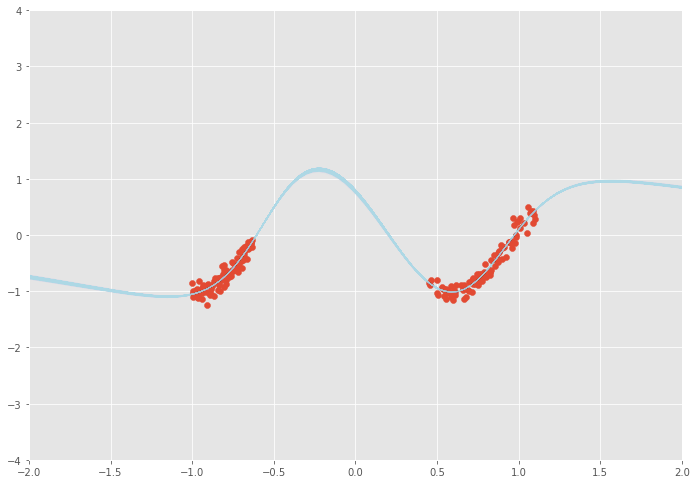

In [708]:
show_variational_posterior_predictive(q)

In [650]:
z = qtoq2(q,100)
D2 = -logprior(z).squeeze(0)
D2

tensor(247.3306, grad_fn=<NegBackward>)

In [651]:
Z = []

In [685]:
D2

tensor(159.7075, grad_fn=<SqueezeBackward1>)

In [678]:
torch.stack(Z).shape

torch.Size([50, 1])